In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 35

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "Dataset-potato",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

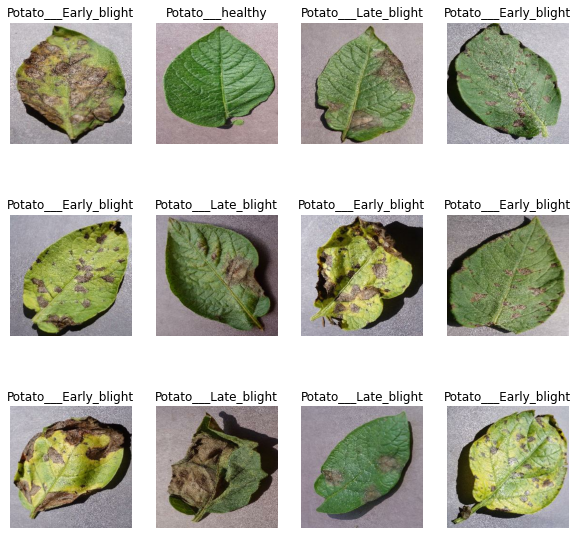

In [21]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/35
54/54 [==============================] - 114s 2s/step - loss: 2.2947 - accuracy: 0.5561 - val_loss: 0.8047 - val_accuracy: 0.6510
Epoch 2/35
54/54 [==============================] - 99s 2s/step - loss: 0.5857 - accuracy: 0.7795 - val_loss: 0.6128 - val_accuracy: 0.7865
Epoch 3/35
54/54 [==============================] - 102s 2s/step - loss: 0.4270 - accuracy: 0.8426 - val_loss: 0.3510 - val_accuracy: 0.8750
Epoch 4/35
54/54 [==============================] - 110s 2s/step - loss: 0.3822 - accuracy: 0.8420 - val_loss: 0.3600 - val_accuracy: 0.8542
Epoch 5/35
54/54 [==============================] - 106s 2s/step - loss: 0.3092 - accuracy: 0.8773 - val_loss: 0.1922 - val_accuracy: 0.9115
Epoch 6/35
54/54 [==============================] - 107s 2s/step - loss: 0.2162 - accuracy: 0.9138 - val_loss: 0.1455 - val_accuracy: 0.9375
Epoch 7/35
54/54 [==============================] - 104s 2s/step - loss: 0.2047 - accuracy: 0.9184 - val_loss: 0.3540 - val_accuracy: 0.8698
Epoch 8/35
54/

In [14]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 320ms/step - loss: 0.0695 - accuracy: 0.9727


In [16]:
scores

[0.10814893245697021, 0.9609375]

In [36]:
history

In [37]:
history.params


{'verbose': 1, 'epochs': 5, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
history.history['accuracy']

[0.47164350748062134,
 0.7037037014961243,
 0.8373842835426331,
 0.8709490895271301,
 0.8802083134651184,
 0.9270833134651184,
 0.9160879850387573,
 0.9241898059844971,
 0.9010416865348816,
 0.9091435074806213,
 0.9311342835426331,
 0.9293981194496155,
 0.9328703880310059,
 0.9340277910232544,
 0.9021990895271301,
 0.9461805820465088,
 0.9247685074806213,
 0.953125,
 0.9392361044883728,
 0.953125,
 0.9577546119689941,
 0.9299768805503845,
 0.9577546119689941,
 0.9467592835426331,
 0.9456018805503845,
 0.9635416865348816,
 0.9594907164573669,
 0.953125,
 0.9542824029922485,
 0.9484953880310059,
 0.9629629850387573,
 0.9646990895271301,
 0.9646990895271301,
 0.9704861044883728,
 0.9618055820465088]

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

<function matplotlib.pyplot.show(close=None, block=None)>

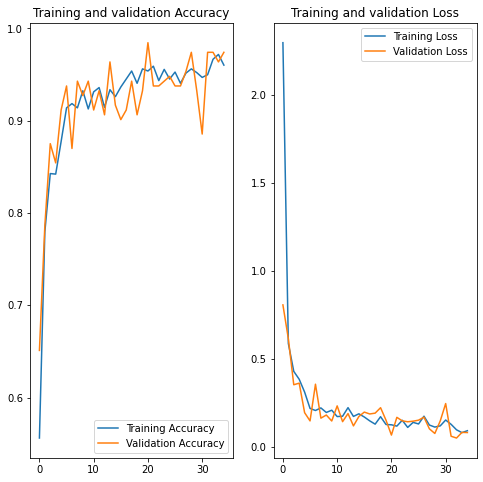

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and validation Loss')
plt.show

First Image to predict
Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight


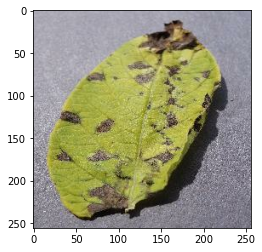

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

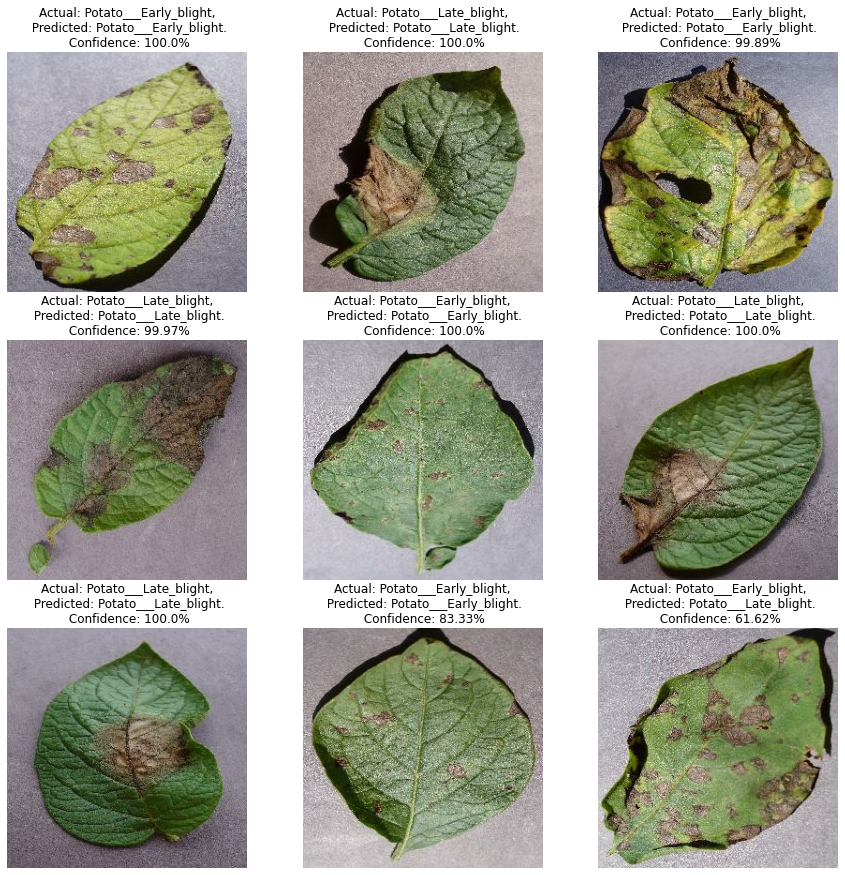

In [25]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

In [24]:
import os
model_version = max([int(i) for i in os.listdir("../save_models") + [0]])+1
model.save(f"../save_models/{model_version}")

INFO:tensorflow:Assets written to: ../save_models/7\assets


In [26]:
model.save("../potatoesv5.h5")

In [70]:
model.save_weights("../potatoesv3.h5")

In [28]:
new_model = tf.keras.models.load_model("../potatoesv3.h5")

ValueError: No model found in config file.

In [33]:
new_model = tf.keras.models.load_model('../potatoesv5.h5')

In [34]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)       

In [31]:
new_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
54/54 [==============================] - 138s 3s/step - loss: 0.1211 - accuracy: 0.9612 - val_loss: 0.2062 - val_accuracy: 0.9271
Epoch 2/5
54/54 [==============================] - 133s 2s/step - loss: 0.1498 - accuracy: 0.9439 - val_loss: 0.1432 - val_accuracy: 0.9323
Epoch 3/5
54/54 [==============================] - 130s 2s/step - loss: 0.1273 - accuracy: 0.9514 - val_loss: 0.1367 - val_accuracy: 0.9375
Epoch 4/5
54/54 [==============================] - 117s 2s/step - loss: 0.0831 - accuracy: 0.9705 - val_loss: 0.0965 - val_accuracy: 0.9583
Epoch 5/5
54/54 [==============================] - 98s 2s/step - loss: 0.0695 - accuracy: 0.9722 - val_loss: 0.1372 - val_accuracy: 0.9479


In [33]:
scores = new_model.evaluate(test_ds)

8/8 [==============================] - 4s 355ms/step - loss: 0.1081 - accuracy: 0.9609


In [42]:
def predict(new_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

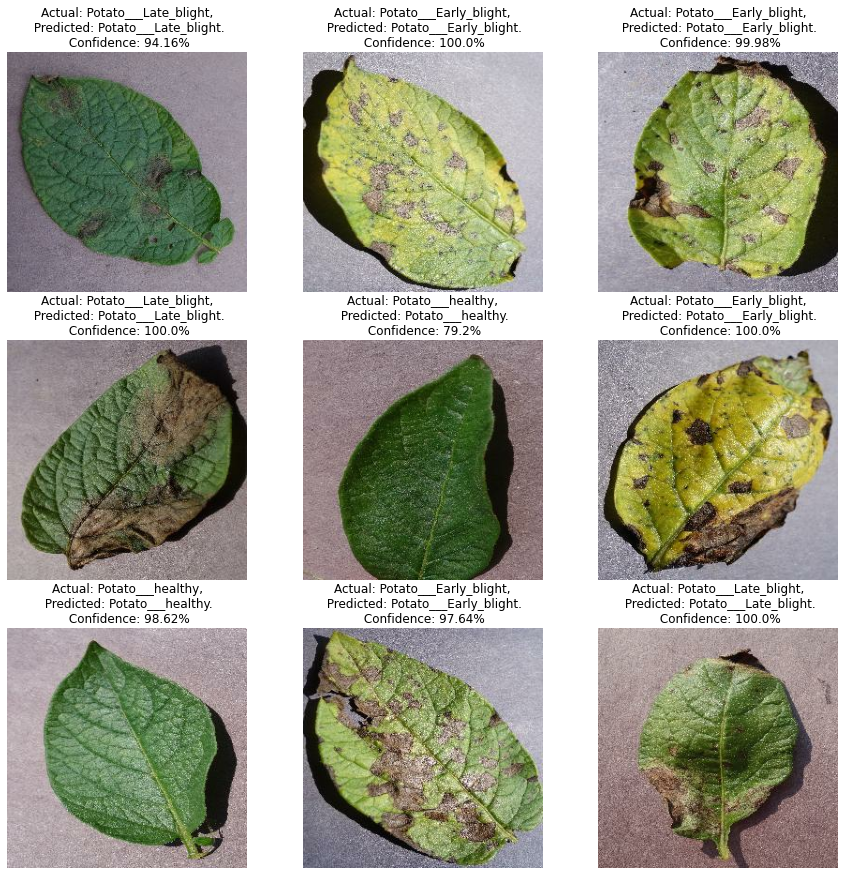

In [45]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')